In [1]:
%%capture
!pip install gensim 
!pip install pyLDAvis

In [2]:
import nltk
import gensim 
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk.tokenize import MWETokenizer, word_tokenize
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS #gensim has longer list of stop words than NLTK
from gensim import corpora
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
import html
import re


In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('./drive/My Drive/tweetc1card.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Date,User,Tweet
0,0,2022-12-22 23:54:09+00:00,MrTrendwatch,Waite what I thought Sammy had 100k and one cr...
1,1,2022-12-22 22:32:06+00:00,stickyisaslut,Cigarettes and sun are fun and sexy until you ...
2,2,2022-12-22 21:46:48+00:00,OmgItsJilly,Here’s my Capital One credit card referral lin...
3,3,2022-12-22 21:32:30+00:00,mirza95815616,How to Respond to Capital One Credit Card Offe...
4,4,2022-12-22 21:30:31+00:00,JarvoDaSlapa,just got that capital one card🤫
...,...,...,...,...
9995,9995,2022-10-24 05:48:05+00:00,twauorg,https://t.co/JBZSlK7FUI Build or rebuild your ...
9996,9996,2022-10-24 03:58:04+00:00,lilHuyosuperb,How does capitalism feel vs how does a common ...
9997,9997,2022-10-24 03:40:29+00:00,brittneybroome,Here’s my Capital One credit card referral lin...
9998,9998,2022-10-24 00:32:00+00:00,thejeffnewton,"@zachmcnair That said, my wife and I recently ..."


new_data = df.drop_duplicates('Tweet',keep='first') #delete the duplicates by dropping them and store the result value to a new variable
new_data.head()

In [5]:
tweets = np.array(df['Tweet'])
tweets[:10]

array(['Waite what I thought Sammy had 100k and one credit card how is he out on 250 million bail hmmmm  he’s gonna get a lot of mile on capital one !',
       'Cigarettes and sun are fun and sexy until you have to start getting shit cut off your face - anyway I’d do it again I was hot and had it all (a studio apartment in West Hollywood and a maxed out capital one card) and now I have a dermatologist 💋 https://t.co/YczRJzIxBL',
       'Here’s my Capital One credit card referral link. Before you apply, you can check if you’re pre-approved with no impact to your credit score: https://t.co/etT04LkpD2',
       'How to Respond to Capital One Credit Card Offer? (2023)\nhttps://t.co/vYj2f2GjXS https://t.co/q6C3yUzgUq',
       'just got that capital one card🤫',
       'I’m really thinking about getting the capital one venture card. Tryna get those points/miles up.',
       '@theficouple The other Capital one biz cards do report to personal (unless that’s changed) but the spark CASH card does 

In [6]:
tweets=[re.sub(r"@\w+", "", x) for x in tweets] # removing username 
tweets=[re.sub(r"http\S+", "",x) for x in tweets]#removing url
tweets=[re.sub(r"#\S+", "",x) for x in tweets] #removing after hashtags
tweets = [re.sub(r"\d+", "",x) for x in tweets]#remove numbers
tweets = [x.lower() for x in tweets]# to lowercase
tweets= [re.sub('\s+', ' ',x).strip('.-!^...') for x in tweets]# remove double spaces
#tweets=[re.sub(r"[.]+", "", x) for x in tweets] # remove elipsis
#tweets=[re.sub(r"[.]{2,3,4}", "", x) for x in tweets]
#tweets=tweets.replace('\u2026','') #remove elipsis
tweets=[re.sub("\.\.\.", "", x)for x in tweets]
tweets[:10]

['waite what i thought sammy had k and one credit card how is he out on million bail hmmmm he’s gonna get a lot of mile on capital one ',
 'cigarettes and sun are fun and sexy until you have to start getting shit cut off your face - anyway i’d do it again i was hot and had it all (a studio apartment in west hollywood and a maxed out capital one card) and now i have a dermatologist 💋 ',
 'here’s my capital one credit card referral link. before you apply, you can check if you’re pre-approved with no impact to your credit score: ',
 'how to respond to capital one credit card offer? () ',
 'just got that capital one card🤫',
 'i’m really thinking about getting the capital one venture card. tryna get those points/miles up',
 ' the other capital one biz cards do report to personal (unless that’s changed) but the spark cash card does not',
 'lmao capital one can’t believe it’s me either 😭 they restricted my credit card and made me verify my identity 🙃',
 ' thanks so much for stopping by meredi

In [7]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)
tweets=[re.sub(emoji_pattern, '', x) for x in tweets]
tweets[:10]

['waite what i thought sammy had k and one credit card how is he out on million bail hmmmm he’s gonna get a lot of mile on capital one ',
 'cigarettes and sun are fun and sexy until you have to start getting shit cut off your face - anyway i’d do it again i was hot and had it all (a studio apartment in west hollywood and a maxed out capital one card) and now i have a dermatologist  ',
 'here’s my capital one credit card referral link. before you apply, you can check if you’re pre-approved with no impact to your credit score: ',
 'how to respond to capital one credit card offer? () ',
 'just got that capital one card',
 'i’m really thinking about getting the capital one venture card. tryna get those points/miles up',
 ' the other capital one biz cards do report to personal (unless that’s changed) but the spark cash card does not',
 'lmao capital one can’t believe it’s me either  they restricted my credit card and made me verify my identity ',
 ' thanks so much for stopping by meredith. 

In [8]:
tweets =list(set(tweets))
tweets[:10]

['ich rede mir halt ein das ich gleich tickets bekomme aber ich habe nicht mal eine capital one card',
 ' i’m planning on using the capital one presale to get taylor swift tickets today. however, my credit limit won’t cover the cost of tickets. it says on the website you can use a mastercard credit card to pay - is this correct?',
 " for today's taylor swift capital one presale, can you use the same capital one card for two different shows?",
 'who would have thought that this many fucking people have a capital one card',
 "me opening a capital one credit card for taylor swift tickets only to find out the virtual card won't work and my physical one may not arrive on time ",
 ' it’s a good day to already have a capital one credit card',
 'got waitlisted for the verified fan codes, never got through the queue with my capital one card, i’ve already got hotel and flights booked for nashville, really hoping tswift has got something up her sleeve to help the fans out. ',
 ' in from the uk an

In [9]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
stopwords = set(STOPWORDS)
more_stopwords = {'capital one','capital one card','card','bank','service','capital','credit','capitalone'}
stopwords = stopwords.union(more_stopwords)
def remove_punctuation(corpus):
    punctuations = r".,\"-\\/#!?$...%\^&\*;:{}=\-_'~()"    
    filtered_corpus = [token for token in corpus if (not token in punctuations)]
    return filtered_corpus
#remove stop words and remove tokens with lenght less than 4 characters
def apply_stopwording(corpus, min_len):
    #black_list = ['capital one','capital one card','card','bank','service','capital']
    filtered_corpus = [token for token in corpus if (not token in stopwords and len(token)>4)]
    #filtered_corpus = [token for token in corpus if (not token in stopwords and not token in black_list and len(token)>4)]
    return filtered_corpus
# apply lemmatization
def apply_lemmatization(corpus):
    lemmatizer = nltk.WordNetLemmatizer()
    normalized_corpus = [lemmatizer.lemmatize(token) for token in corpus]
    return normalized_corpus
#find most common bigrams
def getCollocations(text, min_freq, coll_num):
    bigrams = nltk.collocations.BigramAssocMeasures()
    finderb = BigramCollocationFinder.from_words(text)
    finderb.apply_freq_filter(min_freq)
    collocations = finderb.nbest(bigrams.pmi, coll_num)
    return collocations 

def replaceCollocationsInText(text,collocations):
    first = [t[0]for t in collocations]
    second = [t[1] for t in collocations]

    dtokens = []
    i = 0
    while i<=(len(text)-1):
        try:
            idx1 = first.index(text[i])
            if (text[i+1]==second[idx1]):
                dtokens.append(first[idx1]+"_"+second[idx1]) 
        except:
            dtokens.append(text[i])
            pass
        i=i+1
    return dtokens
def processCorpus(corpus_data):
    #The input is an array of unprocessed text documents
    min_frequency = 3 #only grams that appear 3+ times
    num_of_collocations=100 #top 100 
    text=""
    corpus=[]
    tokens =[]
    
    #Extract corpus and preprocess data
    for line in corpus_data:
        t = nltk.word_tokenize(line) #tokenize each article
        doc = nltk.Text(t)
        doc_clean = nltk.Text(apply_lemmatization(apply_stopwording(remove_punctuation(doc), 3)))
        corpus.append(doc_clean)
        tokens.extend(doc_clean.tokens)
        text=text+line
    
    #Identify collocations
    collocations = getCollocations(tokens,min_frequency,num_of_collocations)
    docs = []
    for doc in corpus:
        t = replaceCollocationsInText(doc,collocations)
        if (len(t)>0):
            docs.append(replaceCollocationsInText(doc,collocations))
    return docs

In [11]:
processDocs = processCorpus(tweets)
print (len(processDocs))
print (processDocs[0:100])

8874
[['gleich', 'ticket', 'bekomme', 'nicht'], ['planning', 'presale', 'taylor', 'swift', 'ticket', 'today', 'limit', 'cover', 'ticket', 'website', 'mastercard', 'correct'], ['today', 'taylor', 'swift', 'presale', 'different', 'show'], ['thought', 'fucking', 'people'], ['opening', 'taylor', 'swift', 'ticket', 'virtual', 'physical', 'arrive'], ['waitlisted', 'verified', 'code', 'queue', 'hotel', 'flight', 'booked', 'nashville', 'hoping', 'tswift', 'sleeve'], ['looked', 'exclusive'], ['verified', 'presale'], ['reasonably_priced', 'priced', 'ticket', 'philly', 'presale'], ['presale', 'tomorrow', 'price', 'nashville', 'disabled', 'aisle', 'health', 'likely', 'going'], ['getting', 'swift', 'presale', 'ticket'], ['verified', 'presale', 'couldn', 'ticket'], ['presale', 'boost', 'ticket', 'girlfriend', 'ticket'], ['question', 'super', 'appreciate', 'answer', 'ticket', 'buying', 'process', 'younger', 'sister', 'multiple', 'ticketmaster', 'account', 'multiple', 'account'], ['year'], ['verified'

In [13]:

doc = nltk.Text(processDocs)
dictionary = gensim.corpora.Dictionary(processDocs)
corpus = [dictionary.doc2bow(doc) for doc in processDocs]
dictionary.token2id

{'bekomme': 0,
 'gleich': 1,
 'nicht': 2,
 'ticket': 3,
 'correct': 4,
 'cover': 5,
 'limit': 6,
 'mastercard': 7,
 'planning': 8,
 'presale': 9,
 'swift': 10,
 'taylor': 11,
 'today': 12,
 'website': 13,
 'different': 14,
 'show': 15,
 'fucking': 16,
 'people': 17,
 'thought': 18,
 'arrive': 19,
 'opening': 20,
 'physical': 21,
 'virtual': 22,
 'booked': 23,
 'code': 24,
 'flight': 25,
 'hoping': 26,
 'hotel': 27,
 'nashville': 28,
 'queue': 29,
 'sleeve': 30,
 'tswift': 31,
 'verified': 32,
 'waitlisted': 33,
 'exclusive': 34,
 'looked': 35,
 'philly': 36,
 'priced': 37,
 'reasonably_priced': 38,
 'aisle': 39,
 'disabled': 40,
 'going': 41,
 'health': 42,
 'likely': 43,
 'price': 44,
 'tomorrow': 45,
 'getting': 46,
 'couldn': 47,
 'boost': 48,
 'girlfriend': 49,
 'account': 50,
 'answer': 51,
 'appreciate': 52,
 'buying': 53,
 'multiple': 54,
 'process': 55,
 'question': 56,
 'sister': 57,
 'super': 58,
 'ticketmaster': 59,
 'younger': 60,
 'year': 61,
 'disappointed': 62,
 'experie

In [14]:
#here asking LDA to extract 5 topics in the data and :

topic_number=5
topic_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=topic_number, id2word = dictionary, passes = 20)
topics = topic_model.print_topics(num_words = 6)

for topic in topics:
    print (topic)

(0, '0.035*"venture" + 0.018*"card" + 0.016*"reward" + 0.015*"travel" + 0.012*"great" + 0.012*"offer"')
(1, '0.075*"queue" + 0.024*"today" + 0.022*"people" + 0.015*"money" + 0.013*"friend" + 0.010*"waiting"')
(2, '0.067*"presale" + 0.033*"digit" + 0.028*"holder" + 0.027*"number" + 0.020*"verified" + 0.019*"think"')
(3, '0.043*"ticket" + 0.041*"purchase" + 0.033*"presale" + 0.031*"account" + 0.020*"debit" + 0.020*"eligible"')
(4, '0.124*"ticket" + 0.088*"presale" + 0.044*"taylor" + 0.027*"tomorrow" + 0.026*"swift" + 0.024*"verified"')


In [15]:
%matplotlib inline
lda_vis = pyLDAvis.gensim_models.prepare(topic_model,corpus,dictionary,sort_topics=False)
pyLDAvis.enable_notebook()
#pyLDAvis.save_html(lda_vis, 'LDA_vis.html') #save 
pyLDAvis.display(lda_vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [16]:
# Each columns is one document 
data_2 = pd.DataFrame.from_records(processDocs).transpose()
data_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8834,8835,8836,8837,8838,8839,8840,8841,8842,8843,8844,8845,8846,8847,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857,8858,8859,8860,8861,8862,8863,8864,8865,8866,8867,8868,8869,8870,8871,8872,8873
0,gleich,planning,today,thought,opening,waitlisted,looked,verified,reasonably_priced,presale,getting,verified,presale,question,year,verified,presale,saying,great,production,think,think,couple,give,completely,holder,soook,tight,worry…,feel,need,today,officially,walmart,taylor,ticket,switched,presale,literally,local,...,hopefully,website,onewhat,dedicated,shouldn,exclusive,saying,counting,tried,getting,swifties,ahhhh,sister,work,heard,verified,digit,welp…,putting,literally,valid,working,website,apology,naniwala,access,presale,waitlisted,believe,card…so,friend,people,approved,waitlisted,getting,taylor,presale,oomfs,check,sister
1,ticket,presale,taylor,fucking,taylor,verified,exclusive,presale,priced,tomorrow,swift,presale,boost,super,None,ticket,holder,None,attempted,mania,separate,cause,month,purchase,unacceptable,going,trying,minnesotan,ticket,None,happened,better,ready,reward,swift,taylor,recently,ticket,everytime,early,...,presale,debit,walletfind,swifties,complaining,presale,house,holder,adding,ticket,None,sorry,ticket,having,referral,horrible,presale,wallet,guess,presale,presale,None,ticket,assistance_product,naman,presale,venture,presale,thankful,excited…wooo,dating,digit,night,None,presale,swift,digit,lmfoaoaoa,None,tried
2,bekomme,taylor,swift,people,swift,code,None,None,ticket,price,presale,couldn,ticket,appreciate,None,loved,None,None,charge,challenge,presale,exclusive,later,single,verified,horrendous,None,updated,None,None,yesterday,yesterday,presale,excellent,telling,None,apple,wanted,watch,access,...,None,None,better,verified,grateful,None,None,None,seatgeek,presale,None,online,None,telling,presale,experience,None,missed,None,think,requirement,None,dream,product_contact,maharlika,digit,member,decent,None,None,maybe,presale,hopefully,None,early,concert,purchase,None,None,today
3,nicht,swift,presale,None,ticket,queue,None,None,philly,nashville,ticket,ticket,girlfriend,answer,None,taylor,None,None,yesterday,football,holder,None,getting,handedly,getting,None,None,None,None,None,today,maybe,None,choice,multi-million,None,right,surprise,sport,None,...,None,None,walmart,code,verified,None,None,None,account,fucked,None,banking,None,qualify,better,anymore,None,ticket,None,general,spend,None,wouldn,contact,bitter,None,holder,seat,None,None,month,tomorrow,help,None,number,None,ticket,None,None,houston
4,None,ticket,different,None,virtual,hotel,None,None,presale,disabled,None,None,ticket,ticket,None,year,None,None,balance,knowledge,verified,None,offer,paying,error,None,None,None,None,None,verified,figured,None,online,dollar,None,actual,sister,cheese,None,...,None,None,world-temp,based,grateful,None,None,None,telling,bought,None,faster,None,honetsly,chance,heard,None,None,None,literally,money,None,conflict,number,nakabayad,None,general,friday,None,None,friend,kicked,None,None,None,None,None,None,None,friday


In [17]:
# Creating a function to get the Subjectivity and Polarity:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# creating a function to create polarity. It tells how positive or negative the text is:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

polarities = []
subjectivities = []

for article in processDocs:
    article_str = ' '.join(article)
    p = getPolarity(article_str) # polarity for the current article
    s = getSubjectivity(article_str)
    polarities.append(p)
    subjectivities.append(s)
    
print(' '.join(processDocs[250]), polarities[250])

year matter guarantee ticket regular verified presale 0.0


In [18]:
articles_list = list(map(lambda article: ' '.join(article), processDocs))
d = {
    'content': articles_list,
    'polarity': polarities,
    'subjectivity': subjectivities
}

newdf = pd.DataFrame(d)
newdf.head()

,content,polarity,subjectivity
0,gleich ticket bekomme nicht,0.0,0.000000
1,planning presale taylor swift ticket today lim...,0.0,0.000000
2,today taylor swift presale different show,0.0,0.600000
3,thought fucking people,-0.6,0.800000
4,opening taylor swift ticket virtual physical a...,0.0,0.142857


In [19]:
#Creating a function to compute negative (-1), Neutral (0) and Positive (+1) Analysis
def getAnalysis(score):  
    if score <0:
          return 'Negative'
    elif score <=0:
          return 'Neutral'
    else:
          return 'Positive'

# Adding a new column analysis with positive and negative:
newdf['analysis'] = newdf['polarity'].apply(getAnalysis)

# Checking the dataset with new column:
newdf.head()

,content,polarity,subjectivity,analysis
0,gleich ticket bekomme nicht,0.0,0.000000,Neutral
1,planning presale taylor swift ticket today lim...,0.0,0.000000,Neutral
2,today taylor swift presale different show,0.0,0.600000,Neutral
3,thought fucking people,-0.6,0.800000,Negative
4,opening taylor swift ticket virtual physical a...,0.0,0.142857,Neutral


In [20]:
# Printing Positive analysis: 
print('Printing positive sentiments:\n')
j=1
sortedDF = newdf.sort_values(by=['polarity']) #Sort the content
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['analysis'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['content'][i])
        print()
        j= j+1

Printing positive sentiments:

1) question super appreciate answer ticket buying process younger sister multiple ticketmaster account multiple account

2) great attempted charge yesterday balance existent worst great seat

3) couple month later getting offer apply worked given called apply pre-approval guaranteed. thanks chime

4) give purchase single handedly paying significant christmas shopping

5) completely unacceptable verified getting error

6) today better yesterday maybe figured having friday hoping karma favor swifties roday

7) officially ready presale

8) walmart reward excellent choice online shopper frequently spend earns

9) switched recently apple right actual number waited

10) local early access

11) apparently friend husband bought ticket tried working reason friend saying fradulent activity thought didnt

12) right

13) digit right

14) interesting member access presale tickets…at arena…

15) luckily worried seat available presale verified work

16) shame luckily ha

In [21]:
# Printing Negative analysis: 
print('Printing negative Sentiments:\n')
j=1
sortedDF = newdf.sort_values(by=['polarity']) #Sort the content
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['analysis'][i] == 'Negative'):
    print(str(j) + ') '+ sortedDF['content'][i])
    print()
    j= j+1

Printing negative Sentiments:

1) thought fucking people

2) presale tomorrow price nashville disabled aisle health likely going

3) verified ticket loved taylor year disappointed experience

4) tight minnesotan updated

5) taylor swift telling multi-million dollar company mistake presale general small percentage holder

6) weird barista asking discount

7) finger_crossed crossed fails

8) signing presale access ridiculous thanking tomorrow presale

9) twice russia annual military budget biden putting trillion

10) unfair managed ticket people debut

11) issue oversold presale needed presales people chance verified fucked

12) eligible presale selected verified sadly option currently

13) annoyed originally asked getting taylor ticket needed today guess

14) heavily debating getting

15) couldn ticket despite verified having tried unable

16) heart_broken broken verified opened error trying check yesterday tomorrow

17) actually signed glendale pre-sale selfish basing conversation gues

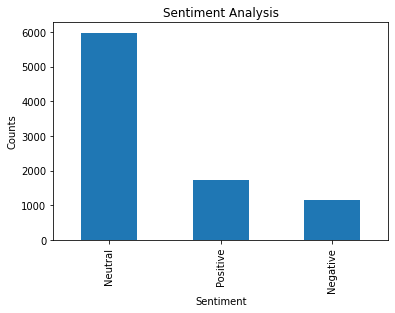

In [22]:
# Plotting and visualizing the counts:
#%matplotlib inline 
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
newdf['analysis'].value_counts().plot(kind = 'bar')
plt.show()

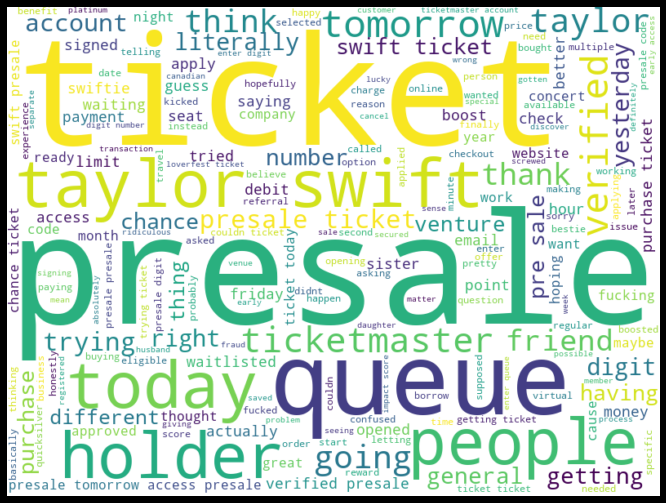

In [26]:
# To see the distribution of the sentiments word cloud is created:
all_articles = ' '.join([content for content in newdf['content']])
wordcloud = WordCloud(stopwords=stopwords, background_color='white',width = 800, height = 600, random_state = 21, max_font_size = 200).generate(all_articles)
plt.figure(figsize=(16,9), facecolor='k')
plt.imshow(wordcloud, interpolation = 'bilinear')
#plt.savefig('CapitalOneWordCloud.png')
plt.savefig(f"./drive/My Drive/c1.png")
#plt.clf()
plt.axis('off')
plt.show()